[*********************100%***********************]  6 of 6 completed


Columns in dataset: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'SPY']
Columns in dataset: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'SPY']
Running backtest...

--- PERFORMANCE SUMMARY ---

               Momentum  Vol_Scaled  Benchmark
Annual Return     0.008       0.006      0.007
Annual Vol        0.011       0.011      0.007
Sharpe            0.680       0.566      0.927
Max Drawdown      0.014       0.015      0.013


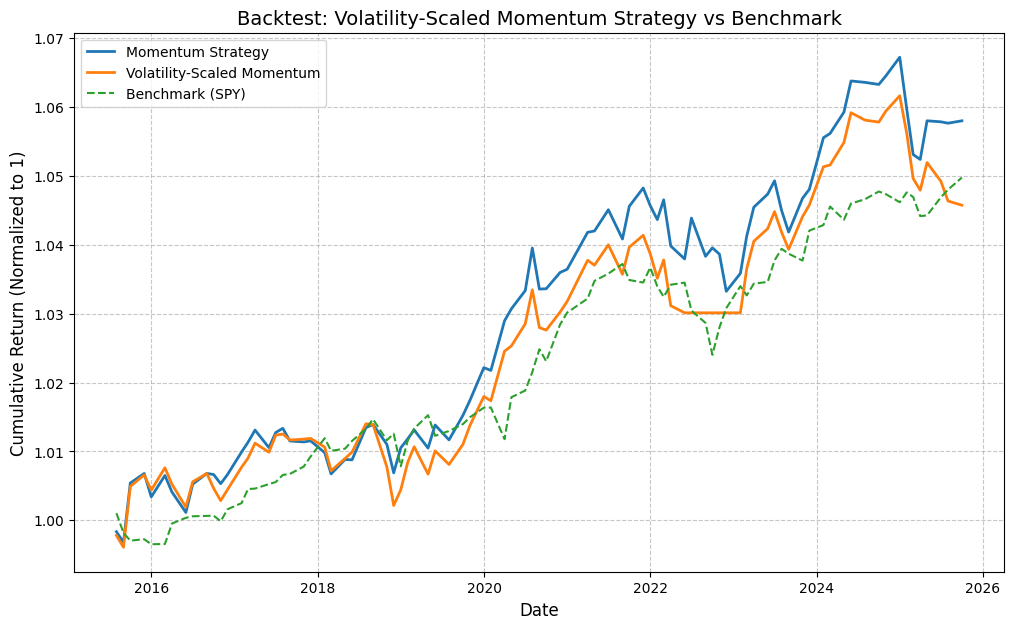


 Backtest complete.


In [6]:
# ============================================================
# Quantitative Research Project: Volatility-Scaled Momentum Strategy
# Author: Samuel Ojum | University of Arizona
# ============================================================

# --- IMPORT LIBRARIES ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META']  # large-cap equities
benchmark = 'SPY'  # S&P 500 ETF
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
lookback = 126   # ~6 months of trading days
rebalance_freq = 'M'  # monthly rebalancing
transaction_cost = 0.001  # 0.1% per trade

# --- DATA DOWNLOAD ---
print("Downloading market data...")
data = yf.download(tickers + [benchmark], start=start_date, end=end_date, auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data = data['Close']
print("Columns in dataset:", data.columns.tolist())

# Flatten column names if yfinance returns MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Confirm structure
print("Columns in dataset:", data.columns.tolist())

# Compute daily returns
returns = data.pct_change().dropna()

# --- FEATURE CONSTRUCTION: MOMENTUM & VOLATILITY ---
momentum = data[tickers].pct_change(lookback).shift(1)
volatility = returns[tickers].rolling(window=lookback).std() * np.sqrt(252)

# --- REBALANCING DATES ---
rebalance_dates = momentum.resample(rebalance_freq).last().index

# --- BACKTESTING ---
port_rets_momentum = []
port_rets_vol_scaled = []
prev_weights_mom = np.zeros(len(tickers))
prev_weights_vol = np.zeros(len(tickers))

print("Running backtest...")
for date in rebalance_dates:
    if date not in returns.index:
        continue

    mom_scores = momentum.loc[date]
    vol_scores = volatility.loc[date]
    if mom_scores.isna().any() or vol_scores.isna().any():
        continue

    # --- STANDARD MOMENTUM STRATEGY ---
    top_stocks = mom_scores.nlargest(3).index
    w_mom = np.array([1/3 if t in top_stocks else 0 for t in tickers])

    # --- VOLATILITY-SCALED MOMENTUM STRATEGY ---
    score = mom_scores / vol_scores
    score = score.replace([np.inf, -np.inf], np.nan).fillna(0)
    score[score < 0] = 0
    w_vol = score / score.sum() if score.sum() != 0 else np.zeros(len(tickers))

    # --- NEXT PERIOD RETURNS (~1 month ahead) ---
    next_month = returns.loc[date:].iloc[1:21]
    if next_month.empty:
        break

    mom_ret = (next_month[tickers] @ w_mom).mean()
    vol_ret = (next_month[tickers] @ w_vol).mean()

    # --- APPLY TRANSACTION COSTS ---
    mom_tc = transaction_cost * np.sum(np.abs(w_mom - prev_weights_mom))
    vol_tc = transaction_cost * np.sum(np.abs(w_vol - prev_weights_vol))
    mom_ret -= mom_tc
    vol_ret -= vol_tc

    port_rets_momentum.append([date, mom_ret])
    port_rets_vol_scaled.append([date, vol_ret])
    prev_weights_mom = w_mom
    prev_weights_vol = w_vol

# --- PERFORMANCE DATAFRAME ---
perf = pd.DataFrame({
    'Momentum': pd.Series(dict(port_rets_momentum)),
    'Vol_Scaled': pd.Series(dict(port_rets_vol_scaled)),
})
benchmark_ret = returns[benchmark].resample(rebalance_freq).mean()
perf['Benchmark'] = benchmark_ret.loc[perf.index]
cum = (1 + perf).cumprod()

# --- PERFORMANCE METRICS ---
def performance_summary(returns):
    ann_ret = (1 + returns.mean())**12 - 1
    ann_vol = returns.std() * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    max_dd = (1 - (1 + returns).cumprod() / (1 + returns).cumprod().cummax()).max()
    return pd.Series({
        'Annual Return': ann_ret,
        'Annual Vol': ann_vol,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd
    })

metrics = perf.apply(performance_summary)
print("\n--- PERFORMANCE SUMMARY ---\n")
print(metrics.round(3))

# --- VISUALIZATION ---
plt.figure(figsize=(12,7))
plt.plot(cum.index, cum['Momentum'], label='Momentum Strategy', linewidth=2)
plt.plot(cum.index, cum['Vol_Scaled'], label='Volatility-Scaled Momentum', linewidth=2)
plt.plot(cum.index, cum['Benchmark'], label='Benchmark (SPY)', linestyle='--', linewidth=1.5)
plt.title('Backtest: Volatility-Scaled Momentum Strategy vs Benchmark', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Normalized to 1)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n Backtest complete.")


In [3]:
!pip install matplotlib